In [1]:
!pip install -q kaggle

In [2]:
!mkdir ~/.kaggle

In [3]:
!cp kaggle.json ~/.kaggle

In [4]:
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!pip install opendatasets

import opendatasets as od
od.download("https://www.kaggle.com/datasets/muratkokludataset/rice-image-dataset")

100%|██████████| 219M/219M [00:01<00:00, 187MB/s]


In [6]:
import tensorflow as tf
print(tf.__version__)

2.15.0


In [45]:
base_dir = 'rice-image-dataset/Rice_Image_Dataset'

In [13]:
import os

# Daftar semua file dan folder dalam base_dir
files_and_folders = os.listdir(base_dir)

# Loop melalui setiap file/folder
for item in files_and_folders:
    # Periksa apakah nama file/folder berisi ".ipynb_checkpoints"
    if ".ipynb_checkpoints" in item:
        # Gabungkan nama file/folder dengan base_dir untuk mendapatkan path lengkapnya
        item_path = os.path.join(base_dir, item)
        # Periksa apakah itu direktori
        if os.path.isdir(item_path):
            # Hapus direktori
            os.rmdir(item_path)
        else:
            # Jika bukan direktori, maka itu adalah file, hapus file
            os.remove(item_path)

In [46]:
os.listdir(base_dir)

['Jasmine', 'Arborio', 'Ipsala', 'Karacadag', 'Basmati']

In [48]:
categories = os.listdir(base_dir)
for category in categories:
    category_dir = os.path.join(base_dir, category)
    num_samples = len(os.listdir(category_dir))
    print(f"Kategori '{category}' memiliki {num_samples} sampel.")

Kategori 'Jasmine' memiliki 15000 sampel.
Kategori 'Arborio' memiliki 15000 sampel.
Kategori 'Ipsala' memiliki 15000 sampel.
Kategori 'Karacadag' memiliki 15000 sampel.
Kategori 'Basmati' memiliki 15000 sampel.


In [44]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    shear_range = 0.2,
                    fill_mode = 'wrap',
                    validation_split=0.2
                    )

test_datagen = ImageDataGenerator(
                    rescale=1./255,
                    )

train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(150, 150),
    class_mode='categorical',
    subset='training'  # Memilih subset latih
)

validation_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(150, 150),
    class_mode='categorical',
    subset='validation'  # Memilih subset validasi
)

Found 60000 images belonging to 5 classes.
Found 15000 images belonging to 5 classes.


In [49]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(512, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])

In [51]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.93 and logs.get('val_accuracy') > 0.93):
      print("Accuracy is more than 92%")
      self.model.stop_training = True
callbacks = myCallback()

In [52]:
# compile model dengan 'adam' optimizer loss function 'categorical_crossentropy'
model.compile(loss='categorical_crossentropy',
              optimizer=tf.optimizers.Adam(),
              metrics=['accuracy'])

# latih model dengan model.fit
hist = model.fit(
    train_generator,
    steps_per_epoch=25,  # berapa batch yang akan dieksekusi pada setiap epoch
    epochs=50, # tambahkan epochs jika akurasi model belum optimal
    validation_data=validation_generator, # menampilkan akurasi pengujian data validasi
    validation_steps=20,  # berapa batch yang akan dieksekusi pada setiap epoch
    verbose=2,
    callbacks=[callbacks]
)

Epoch 1/50
25/25 - 12s - loss: 0.6598 - accuracy: 0.7688 - val_loss: 0.5153 - val_accuracy: 0.8484 - 12s/epoch - 497ms/step
Epoch 2/50
25/25 - 10s - loss: 0.3358 - accuracy: 0.8888 - val_loss: 0.1911 - val_accuracy: 0.9219 - 10s/epoch - 385ms/step
Epoch 3/50
25/25 - 10s - loss: 0.2351 - accuracy: 0.9150 - val_loss: 0.1809 - val_accuracy: 0.9281 - 10s/epoch - 382ms/step
Epoch 4/50
25/25 - 9s - loss: 0.2398 - accuracy: 0.9162 - val_loss: 0.2305 - val_accuracy: 0.9125 - 9s/epoch - 364ms/step
Epoch 5/50
Accuracy is more than 92%
25/25 - 10s - loss: 0.1998 - accuracy: 0.9337 - val_loss: 0.1772 - val_accuracy: 0.9328 - 10s/epoch - 415ms/step


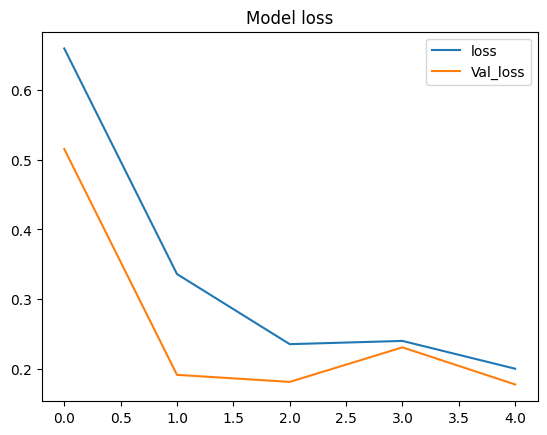

In [53]:
import matplotlib.pyplot as plt

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.legend(['loss', 'Val_loss'],  loc='upper right')
plt.show()

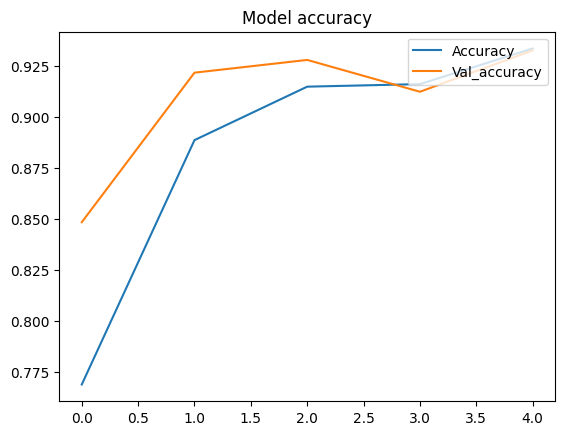

In [54]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.legend(['Accuracy', 'Val_accuracy'],  loc='upper right')
plt.show()

In [55]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)